In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

from helpers.readers import prepare_dataframes

In [2]:
movies, directors, awards = prepare_dataframes()

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


# Get scores for movies and directors

In [3]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [4]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

# Look at the director scores temporally

In [5]:
genres = []
for item in movies.dropna(subset='genres').genres.str.split(','):
    genres.extend(item)
genres = set(genres)

print(f'We have {len(genres)} genres.')

We have 364 genres.


In [6]:
genres = []
for item in movies.dropna(subset='genres_imdb').genres_imdb.str.split(','):
    genres.extend(item)
genres = set(genres)

print(f'We have {len(genres)} genres.')

We have 28 genres.


We go on with the IMDb genres since they seem to be more general (only 28) than the CMU genres.

In [7]:
def get_genres(movies):
    """Returns a dataframe with a row for each genre in each released movie."""

    directed_genres = []
    for _, movie in movies.iterrows():
        if isinstance(movie.genres_imdb, str):
            directed_genres.extend([(movie.release, g) for g in movie.genres_imdb.split(',')])

    gs = pd.DataFrame(directed_genres).rename(columns={0: 'release', 1: 'genre'})
    if len(gs):
        gs['isNew'] = gs.apply(lambda row: row.genre not in gs.query('release < @row.release').genre.tolist(), axis=1)

    return gs


In [8]:
def avgtop(movies, n=3):
    """Returns the avg-n score from a list of movies."""

    if len(movies.score.dropna()) < n:
        return pd.NA
    else:
        return movies.score.sort_values(ascending=False)[:n].mean()

In [9]:
def metric_ts(metric, movies, **kws):
    """Returns a metric from a list of movies as a timeseries."""

    ts = pd.DataFrame([
        (year, metric(movies[movies.release <= year], **kws))
        for year in movies.release.unique().tolist()
    ])
    ts = ts.rename(columns={0: 'release', 1: 'score'}).dropna()

    return ts

In [10]:
def plot_genre_evolution(director):
    fig, ax = plt.subplots(figsize=(18, 4))

    # Get list of directed movies
    directed_movies = movies[movies.directors.str.contains(director.name)]

    # Plot genre histogram
    sns.histplot(
        ax=ax,
        data=get_genres(directed_movies),
        x='release',
        y='genre',
        discrete=(True, True),
        hue='isNew',
        # color='#4CB391',
    )

    axright = ax.twinx()
    # Plot score evolution
    sns.lineplot(
        ax=axright,
        data=metric_ts(avgtop, directed_movies, n=3),
        x='release',
        y='score',
        color='black',
        marker='o',
        label='top-3 score average',
    )
    # Plot score per movie
    sns.lineplot(
        ax=axright,
        x=directed_movies.dropna(subset=['score', 'release']).release.astype(float),
        y=directed_movies.dropna(subset=['score', 'release']).score,
        color='black',
        marker='X',
        label='single release score',
    )

    ax.grid()
    ax.set(title=director.primaryName)
    axright.legend(loc='lower center')
    ax.set_xticks(directed_movies.release.unique().tolist())
    ax.set_xticklabels(directed_movies.release.unique().tolist(), rotation='vertical')
    plt.tight_layout()
    plt.show()

    return fig

We can look at the style evolution of a single person using the `plot_genre_evolution` plot:

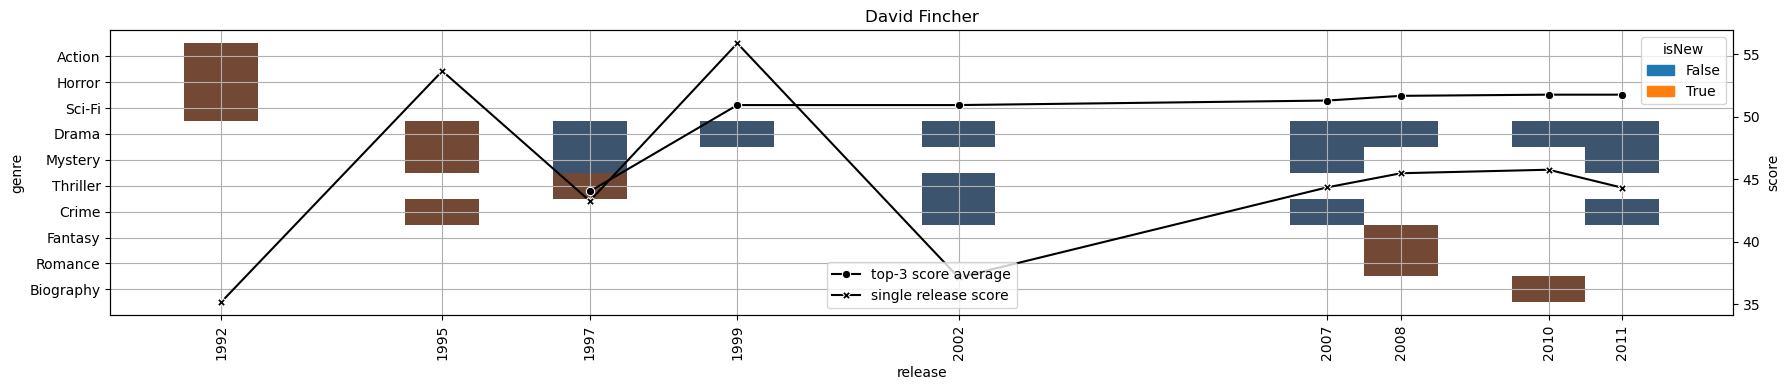

In [11]:
_ = plot_genre_evolution(directors.loc['nm0000399'])

Let's extend the movies dataframe and add two columns:

- `directorNewGenre`: Whether the director explored a new genre in this movie
- `directorCareerYears`: Years passed in the director's career at the release time of the movie

In [12]:
movies['directorNewGenre'] = False
movies['directorCareerYears'] = pd.NA


for nconst in tqdm.tqdm(directors.index):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(nconst)]

    # Add the years passed after beginning the career of the director
    if not len(director_movies):
        continue
    directorCareerYears = director_movies.release.astype(float) - director_movies.release.min()
    movies.directorCareerYears.update(other=directorCareerYears)

    # Add whether a new genre is explored by the director in this movie
    director_genres = get_genres(director_movies)
    if not len(director_genres):
        continue
    directorNewGenre = director_movies.dropna(subset=['genres_imdb', 'release']).apply(lambda row: director_genres.query('release == @row.release').isNew.any(), axis=1)
    movies.directorNewGenre.update(other=directorNewGenre)


100%|██████████| 28478/28478 [20:42<00:00, 22.92it/s]   


# Analyze the correlations

In [13]:
import statsmodels.formula.api as smf

Let's first add a column that determines whether the directors is considered as successful or not:

In [14]:
# movies.loc['tt1668191', 'release'] = 2010  # TODO: Clean in the beginning of the notebook

In [15]:
movies = movies.dropna(subset='directors').copy()
directors_successful = directors[directors['avg-3'] > 40].index.tolist()
movies['directorIsSuccessful'] = movies.apply(lambda row: any([d in directors_successful for d in row.directors.split(',')]), axis=1)

In [16]:
movies_ = movies.copy()
movies_ = movies_.dropna(subset=['directorCareerYears', 'score']).query('directorCareerYears < 60')
movies_ = movies_.query('runtime > 20')  # Exclude short films
movies_ = movies_.query('runtime < 500')  # Exclude very long movies

In [17]:
movies_.directorCareerYears.fillna(movies_.directorCareerYears.mean(), inplace=True)
movies_.directorCareerYears = movies_.directorCareerYears.astype(float)
movies_.directorNewGenre = movies_.directorNewGenre.astype(int)

In [18]:
def normalize(s: pd.Series):
    return (s - s.mean()) / s.std()

movies_['runtimeNormalized'] = normalize(movies_.runtime)
movies_['directorCareerYearsNormalized'] = normalize(movies_.directorCareerYears)

A one-hot representation of the IMDb genres is very much sensible here.


## Correlation between a director’s critical success and evolution of their style regarding movie genres


Not easy to quantize "evolution of their style."

We can try to analyze the correlation between the `directorNewGenre` and the score of the movie

In [19]:
model = smf.ols('score ~ runtime + directorNewGenre + directorCareerYears', data=movies_.query('directorIsSuccessful == True')).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     192.2
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          8.26e-110
Time:                        22:40:00   Log-Likelihood:                -7385.6
No. Observations:                2052   AIC:                         1.478e+04
Df Residuals:                    2048   BIC:                         1.480e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.1431    

> Small but significant correlation between `directorNewGenre` and `score`.

> Large and significant correlation between `runtime` and `score`.

## To what extent do directors experiment with new genres and thematics over the course of their career, and is there a pattern of periods of experimentation followed by periods of consistency 



In [20]:
movies_.directorCareerYears.max()

59.0

In [21]:
print('*' * 100)
print('Correlations among all directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYearsNormalized', data=movies_).fit()
print(model.summary())

print(' ' * 100)

print('*' * 100)
print('Correlations among successful directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYearsNormalized', data=movies_[movies_.directorIsSuccessful]).fit()
print(model.summary())
print(' ' * 100)

****************************************************************************************************
Correlations among all directors:
****************************************************************************************************
                                                                                                    
                            OLS Regression Results                            
Dep. Variable:       directorNewGenre   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                 1.397e+04
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:40:00   Log-Likelihood:                -26800.
No. Observations:               50648   AIC:                         5.360e+04
Df Residuals:                   50646   BIC:                         5.362e+04
Df Model:                      

> Intercept: Probability of exploring a new genre in a movie with average years through the career.

> Coefficient: Increase in probability with 1 std (~10 years) more through the career.

> There is a negative correlation.

The negative correlation might be due to the fact that in the first years, every genre is considered a new genre.

Let's do the same analysis considering only movies after a decade through the career of the directors.

In [22]:
model = smf.ols('directorNewGenre ~  directorCareerYearsNormalized', data=movies_.query('directorCareerYears > 10')).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       directorNewGenre   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          9.68e-112
Time:                        22:40:00   Log-Likelihood:                -11129.
No. Observations:               15996   AIC:                         2.226e+04
Df Residuals:                   15994   BIC:                         2.228e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

<Axes: xlabel='directorCareerYears', ylabel='directorNewGenre'>

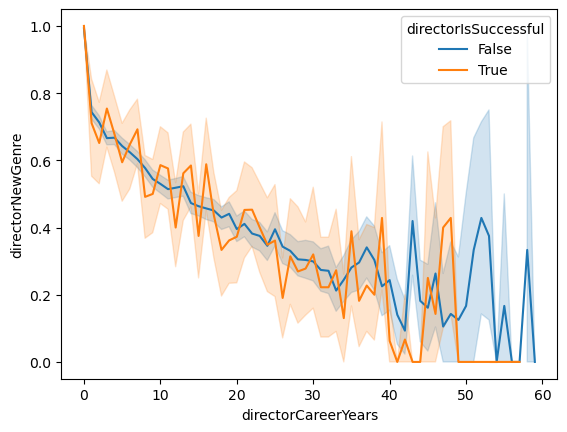

In [23]:
sns.lineplot(
    data=movies_,
    x='directorCareerYears',
    y='directorNewGenre',
    hue='directorIsSuccessful'
)

> Not surprisingly, there is general trend of less tendency to try a new genre as the years pass in a director's career.

# Work in progress

## Are directors who tend to work on more diverse projects less successful ?

Extend the codes in `clemence_P3.ipynb`.

We can identify these directors by looking at the number of genres that .

In [24]:
def get_num_genres(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return int(director_movies.directorNewGenre.sum())

In [25]:
directors['genresExplored'] = directors.apply(get_num_genres, axis=1)

In [26]:
directors_ = directors.rename(columns={'avg-3': 'avg3'})

In [27]:
model = smf.ols('"avg3" ~  genresExplored', data=directors_.dropna(subset=['avg3', 'genresExplored'])).fit()
print(model.summary())

PatsyError: Number of rows mismatch between data argument and "avg3" (6508 versus 1)
    "avg3" ~  genresExplored
    ^^^^^^

## Are more successful directors more often specialized in a certain combination of genres ?

Extend the codes in `clemence_P3.ipynb`.

1. Calculate the percentage of their movies in each genre / genre combinations (2 or 3).

2. Look at the highest percentage.

# TODO: # genres vs. success score of the director

# TODO: (avg. # genres per movie) vs. success score of the director